# SEIR model with data for Santa Cruz County
 * This notebook is used for starting the SEIR model in May 2021.
 * Initial conditions and parameter estimates were generated from a previous model simulation and copied here:
   1. variable/compartment initial conditions (`mu_x_ini_2to10`, `sigma_x_ini_2to10`, `V_ini`)
   2. initial $\beta$ estimates (`mu_beta1`, `sigma_beta1`) 
   3. duration parameters (`mu_duration_lat`, etc.)
   4. log-linear intercept and slope parameters (`frac_hospmild_i45`, etc.)
 * To modify with you own data or parameters edit the cells underneath the "**user input:**" header below.

### some preparation

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import pystan
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
from dateutil.parser import parse

data = {'prior_only':[0,0,0,0]}

# user input:

The model requires three data types that are read from CSV or Excel files:
 1. `cases`: the (cumulative) number of confirmed cases of COVID-19.
 2. `deaths`: the (cumulative) number of deaths due to COVID-19.
 3. `hospitalizations`: the (current) number of hospitalized (ICU and non-ICU) patients and the (current) number of ICU patients due to COVID-19.

For each of the data types above, the variable `datafileinfo` contains the information required to find the data. For each datatype, it must contain the following entries:
 * `filename`: The data file name. Comma-separated values (CSV) and Excel files are accepted. See [example file](data/santa_cruz_cases.xlsx). If a single file contains more than one data type (like confirmed cases and deaths), the same file name can be used for those data types.
 * `columnname` (`columnnames` for `hospitalizations`): The column name for that data type in the file. Hospitalizations requires *two* column names for (1) the of number of hospitalized (ICU and non-ICU) patients and (2) the number of ICU patients.
 * `datecolumnname`: The column name of the associated date column in the file.

**Note:** If you are unsure if the data was read in correctly, check the first plot below, it should contain all types of data.

In [2]:
# the names of the data files
datafileinfo = {
    'cases': {
        'filename': 'data/sc_data_agestructured_binmode6.csv', 
        'columnnames': ('age 0 to 24', 'age 25 to 50', 'age 51 to 99'), 
        'datecolumnname': 'date'
    },
    'deaths': {
        'filename': 'data/sc_deaths.csv', 
        'columnnames': ('deaths',), 
        'datecolumnname': 'date',
    },
    'hospitalizations': {
        'filename': 'data/sc_hospitalization.csv', 
        'columnnames': ('positive-patients', 'positive-icu'), 
        'datecolumnname':'date',
    },
    'immunizations': {
        'filename': 'data/sc_immunizations_binmode6_extended.csv', 
        'columnnames': ('age 0 to 24', 'age 25 to 50', 'age 51 to 99'), 
        'datecolumnname':'date',
    },
}

age_group_desc = datafileinfo['cases']['columnnames']

# the start date at which to start the simulation
startdate_str = '2021-05-01'
startdate = parse(startdate_str)

# the date up to which to include observation for fitting (typically today)
rewinddate = datetime.datetime.now()

# the number of days to run the model for
data['nt'] = max(100, (rewinddate - parse(startdate_str)).days + 61)

The model permits the specification of multiple age groups of the susceptiple population and the fraction of infected who require non-ICU hospitalization (`frac_hospmild`), ICU hospitalization with recovery (`frac_iculive`), the mortality rate of infected (`frac_mort`) and the fraction of asymptomatic cases (`frac_asym`) for each age group. The remaining cases are assumed to be "mild" cases who recover at home. 

The fraction of asymptomatic cases (`frac_asym`) need to specified for each age group.

A log-linear age-dependence is assumed for non-ICU hospitalization, ICU hospitalization with recovery, and mortality, leading to an exponential increase in these outcomes with age. The model estimates slope and intercept (at age 45, roughly the center of the age spread) of the log-linear relationship. Both slope an intercept use normal distribution as priors. The parameters `mu_frac_hospmild_i45` and `sigma_frac_hospmild_i45` specify the mean and standard deviation of the intercept for non-ICU hospitalization, and `mu_frac_hospmild_slope` and `sigma_frac_hospmild_slope` specify mean and standard deviation for its slope. Mean and standard deviation for the other outcomes are specified analogously. 

The fraction of infectious cases are modeled using a Dirichlet distribution. The parameter `alpha_multiplier` adjusts the variance of the prior distribution for each fraction thereby allowing fractions to be estimated by the model (for lower values of `alpha_multiplier`, e.g. 100) or to remain fixed (higher values of `alpha_multiplier`, e.g. 1000). It is not recommended to estimate fractions if `nage` (above) is greater than 1, that is if multiple age groups are used.

In [3]:
# the number of age groups
data['nage'] = 3

# Note: The inputs below must be lists or arrays, even if just one age group is specified
# (the enclosing "[]" are not optional).

# age bin edges: 0, 25, 51, 100
data['npop'] = np.array([89724, 91178, 92862])
data['age'] = np.array([20, 38, 65])

# fraction of asympotmatic for each age group
data['frac_asym'] = np.full(data['nage'], fill_value=0.178)

'''
posterior estimates from model simulation that generated restart
                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
frac_hospmild_i45    -2.13  1.5e-3   0.04   -2.2  -2.16  -2.13   -2.1  -2.04    754    1.0
frac_hospmild_slope   0.03  2.1e-4 9.0e-3   0.01   0.02   0.03   0.04   0.05   1805    1.0
frac_iculive_i45     -3.48  5.4e-3   0.17  -3.84  -3.59  -3.47  -3.36  -3.15   1021   1.01
frac_iculive_slope    0.03  2.7e-4 9.9e-3   0.01   0.02   0.03   0.04   0.05   1334    1.0
frac_mort_i45        -2.77  6.6e-4   0.02   -2.8  -2.78  -2.77  -2.76  -2.74    573    1.0
frac_mort_slope       0.04  2.8e-4 9.9e-3   0.02   0.03   0.04   0.05   0.06   1216    1.0
'''

# mean and standard deviation of the intercept (at age 45) for non-ICU hospitalization
data['mu_frac_hospmild_i45'] = -2.13
data['sigma_frac_hospmild_i45'] = 0.04

# mean and standard deviation of the slope for non-ICU hospitalization
data['mu_frac_hospmild_slope'] = 0.03
data['sigma_frac_hospmild_slope'] = 9.0e-3

# mean and standard deviation of the intercept (at age 45) for ICU hospitalization with recovery
data['mu_frac_iculive_i45'] = -3.48
data['sigma_frac_iculive_i45'] = 0.17

# mean and standard deviation of the slope for ICU hospitalization with recovery
data['mu_frac_iculive_slope'] = 0.03
data['sigma_frac_iculive_slope'] = 9.9e-3

# mean and standard deviation of the intercept (at age 45) for mortality
data['mu_frac_mort_i45'] = -2.77
data['sigma_frac_mort_i45'] = 0.02

# mean and standard deviation of the slope for mortality
data['mu_frac_mort_slope'] = 0.04
data['sigma_frac_mort_slope'] = 9.9e-3

# a parameter modifying the prior uncertainty in the fractions above (set to 1000.0 for `nage` > 1)
data['alpha_multiplier'] = 1000.0

The following parameters specify the prior distribution for the model parameters. Most of the parameters are modeled by a normal distribution for which a mean ($\mu$, `mu_*`) and standard deviation ($\sigma$, `sigma_*`) need to be specified.

Currently, the initial conditions at the start date of the simulation assume zero infectious cases and a small number of exposed individuals. The prior distribution for the number of initially exposed individuals is modeled using an exponential distribution with a parameter `lambda_ini_exposed`. 1/`lambda_ini_exposed` is the mean of the distribution.

In [4]:
# rounded from the output of the notebook that generated these values for 
# Santa Cruz county and the 2021-05-01 restart date

# mean duration in "exposed" stage
data['mu_duration_lat'] = 4.0
# standard deviation (sd) of duration in "exposed" stage
data['sigma_duration_lat'] = 1.0
# mean duration in "infectious" stage for asymptomatic cases
data['mu_duration_rec_asym'] = 7.0
# sd of duration in "infectious" stage for asymptomatic cases
data['sigma_duration_rec_asym'] = 3.0
# mean duration in "infectious" stage for mild cases
data['mu_duration_rec_mild'] = 5.0
# sd of duration in "infectious" stage for mild cases
data['sigma_duration_rec_mild'] = 2.0
# mean duration in "infectious" stage for hospitalized cases
data['mu_duration_pre_hosp'] = 7.0
# sd of duration in "infectious" stage for hospitalized cases
data['sigma_duration_pre_hosp'] = 1.0
# mean duration in hospital for non-ICU cases
data['mu_duration_hosp_mod'] = 8.0
# sd of duration in hospital for non-ICU cases
data['sigma_duration_hosp_mod'] = 1.0
# mean duration in hospital for ICU cases
data['mu_duration_hosp_icu'] = 7.0
# sd of duration in hospital for ICU cases
data['sigma_duration_hosp_icu'] = 1.0

# lambda parameter for initial conditions of "exposed"
data['lambda_ini_exposed'] = 0.3

The following 4 parameters are related to the fitting of observations in the model. Each of the 4 observation types (confirmed cases (`Iobs`), non-ICU + ICU hospitalizations (`H`), ICU hospitalizations (`Hicu`), and deaths (`Rmort`)) has its own observation uncertainty, and the misfit between model and observations varies between the types. The standard deviation of the model-observation misfit is assumed to have an exponential distribution with a parameter $\lambda$ (`lambda`). The 4 parameters below specify the value of $\lambda$ for each observation type. Because $1/\lambda$ is the mean of an exponential distribution, a larger value of a specific $\lambda$ presumes a tighter fit to the corresponding observation type and lowering the value loosens the fit.

The current default presumes a tighter fit to the mortality data (larger value of `lambda_Rmort`) and a looser fit to confirmed case count (lower value of `lambda_Iobs`) with the hospitalization data in between.

In [5]:
# lambda parameter for Iobs observation misfit
data['lambda_Iobs'] = 0.03
# lambda parameter for Hmod observation misfit
data['lambda_H'] = 3.0
# lambda parameter for Hicu observation misfit
data['lambda_Hicu'] = 1.0
# lambda parameter for Rmort observation misfit
data['lambda_Rmort'] = 10.0

The next set of parameters are related to the fraction of infectious who have been tested, which links newly infectious in the model to the confirmed cases in the data. We assume time-dependence in the prior, e.g. to account for an increase in testing.

With time-dependence, the time-evolution of the fraction tested is prescribed using a spline curve of degree `p_fractest`. Using `p_fractest = 1` (like below), uses linear interpolation in time to describe the time-evolution of the fraction tested prior: At a set of time points, normal distributions are prescribed (using mean and standard deviation of the fraction of newly infectious who get tested) which are interpolated between the knots. Use `create_spline_plot = True` to create a plot of the interpolation result before running the Stan model.

In [6]:
# the order of the splines used (set to 1 for linear interpolation)
data['p_fractest'] = 1

# the time-points at which to prescribe a new distribution
# Note: The first entry must be the start day, the last must be the last day of the simulation
# (if this is not the case they are automatically corrected).
dates_fractest_str = [startdate_str, '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01']

# mean fraction of tested infectious (one entry for every entry in dates_fractest_str above)
data['mu_fractest'] = np.array([0.8,0.8,0.8,0.8,0.8]) / 0.8 * 0.3
# sd fraction of tested infectious(one entry for every entry in dates_fractest_str above)
data['sigma_fractest'] = np.array([0.05,0.05,0.05,0.05,0.05]) / 0.8 * 0.3

# If create_spline_plot is set to true, a plot of the interpolation result
# for the mean of the prior distribution) is created below the data plot.
create_spline_plot = False

The next set of parameters is used to account for a background level of "imported" infectious individuals. These imports represent both infectious individuals entering the model region (visitors to Santa Cruz county) as well as infectious individuals encountered outside the model region by individuals from the model region (Santa Cruz county residents visiting other places).

Just like the fraction tested above, imports are modeled using splines using the same time-points. 

In [7]:
# the order of the splines used (set to 1 for linear interpolation)
data['p_imports'] = 1

# mean of number of imports (one entry for every entry in dates_fractest_str above)
data['mu_imports'] = np.array([2.0, 2.0, 2.0, 2.0, 2.0])

# standard deviation of number of imports (one entry for every entry in dates_fractest_str above)
data['sigma_imports'] = np.array([1.0, 1.0, 1.0, 1.0, 1.0])

The model also requires the specification of the distribution for the initial value of $\beta$ using a normal distribution with mean `mu_beta1` and standard deviation `sigma_beta1`.

The remaining values for $\beta$ are estimated based on the input data every `dknot` days (using an AR(1) process and Spline interpolation). The spline interpolation offers two transition modes to extrapolate the values of $\beta$ beyond the current date after which no data is available. Setting `splinemode` to 1 will allow the spline to be estimated freely until the current date. The more conservative option `splinemode` = 2 assumes a constant value for $\beta$ in the last `dknot` days before the current date.    

In [8]:
'''
estimates from model simulation that generated restart
mean beta: [0.08871386 0.14129522 0.10782254]
sd beta:   [0.03295604 0.0419682  0.04301105]
'''

data['mu_beta1'] = np.array([0.088714, 0.141295, 0.107823])
data['sigma_beta1'] = 0.039

# distance in time between the knots used to construct the splines
data['dknot'] = 10

# itoday_1based is the (1-based) time index corresponding to the current date
itoday_1based = (rewinddate-parse(startdate_str)).days + 1
# specify the date up to when beta is estimated
data['itoday'] = itoday_1based

# spline mode (must be 1 or 2)
# splinemode = 1: estimate beta up to today
# splinemode = 2: estimate beta up to dknot days before today, then assume constant value up to today
data['splinemode'] = 1

Interventions permit the modification of $\beta$ past the current date. `ninter` is the number of interventions (allowed to be zero for no interventions). Each intervention has a start time (`t_inter`) and a length (in days) over which $\beta$ is adjusted. Each intervention leads to a multiplication of the value of $\beta$ before the intervention with a random number drawn from a normal distribution with mean `mu_beta_inter` and standard deviation `sigma_beta_inter`. That is, an intervention with `mu_beta_inter` set to 1.2 will lead to an average increase in $\beta$ by 20%, 0.8 to an average decrease by 20%; a value of 1.0 will lead to no mean increase but a higher spread (less certainty) in the value of $\beta$ after the intervention.

In [9]:
# number of interventions
data['ninter'] = 1

# Note: The inputs below must be lists or arrays, even if one intervention is specified
# (the enclosing "[]" are not optional for single interventions).

# start time of each interventions
data['t_inter'] = [itoday_1based+5]
# length of each intervention
data['len_inter'] = [10]
# mean change in beta through intervention
data['mu_beta_inter'] = [1.0]
# sd change in beta through intervention
data['sigma_beta_inter'] = [0.2]

**Options for restart:** For a model start with a non-zero number of individuals that are infectious, hospitalized, vaccinated etc., the model requires the specification of distributions for the number of individuals in each compartment at the beginning of the simulation.

A lognormal distribution is used to estimate the initial number of exposed individuals (compartment 2); normal distributions are used for the initial conditions of compartments 3 to 10. Both distributions require the specification of $\mu$ and $\sigma$ values, one for each age group. These are specified via the `mu_x_ini_2to10` and `sigma_x_ini_2to10` parameters (which contain `2to10` in their name to indicate that they specify the initial conditions for compartments 2 to 10).

The paramater `V_ini` specifies the total number of immunized (vaccinated) inidividuals in each age group. To compute the number of vaccinated (previously recovered) individuals (compartment 11), the model creates an estimate for the number of vaccinated (previously susceptible; compartment 10) and subtracs that number from `V_ini`.

To obtain the initial estimate for the number of susceptible individuals (compartment 1), the model subtracts the sum of individuals in compartments 2 through 11 from the total population (specified by the parameter `npop`, see above).

In [10]:
# estimates from model simulation that generated restart

data['mu_x_ini_2to10'] = np.array((
      (    3.444,     3.498,     2.810), # exposed (lognorm)
      (   10.911,    11.752,     6.262), # infectious (norm)
      (   34.910,    37.238,    18.962), # recovering at home (norm)
      (    0.100,     0.392,     1.521), # pre-hospital (norm)
      (    0.107,     0.407,     1.419), # hospitalized (non-ICU) (norm)
      (    0.015,     0.080,     0.468), # ICU (norm)
      (19168.830, 19860.837,  7321.913), # recovered (norm)
      (    3.159,    23.345,   178.211), # deceased (norm)
      ( 4326.259, 20355.454, 45601.950), # vaccinated (previously susceptible) (norm)
   )).T

data['sigma_x_ini_2to10'] = np.array((
      (    0.324,     0.259,     0.394), # exposed (lognorm)
      (    6.673,     7.091,     4.102), # infectious (norm)
      (   13.892,    14.510,     9.086), # recovering at home (norm)
      (    0.025,     0.076,     0.430), # pre-hospital (norm)
      (    0.019,     0.056,     0.300), # hospitalized (non-ICU) (norm)
      (    0.003,     0.013,     0.110), # ICU (norm)
      (  713.950,   751.292,   285.387), # recovered (norm)
      (    0.076,     0.429,     0.658), # deceased (norm)
      (   47.368,   364.511,   453.400), # vaccinated (previously susceptible) (norm)
   )).T

data['V_ini'] = np.array([5575.0, 29761.0, 56952.0])

**Advanced options for performing multiple simulations (leave unchanged if not needed)**. The parameter `stan_file` specifies Stan code file used in the simulation. `datachanges` allows running multiple simulations with different parameters (optional).

In [11]:
data['knots_age'] = data['age']
data['nknots_age'] = len(data['knots_age'])

stan_file = {'SEIR':'stan_code/seir_v12b.continue-v2.stan'}

# define alternative parametrizations here (optional, comment out if not needed)
datachanges = {
    'v12b':None,
    #'v12b_14+20':{'ninter':1, 't_inter':[itoday_1based], 'len_inter':[14], 'mu_beta_inter':[1.2], 'sigma_beta_inter':[0.1]},
    #'v12b_14+50':{'ninter':1, 't_inter':[itoday_1based], 'len_inter':[14], 'mu_beta_inter':[1.5], 'sigma_beta_inter':[0.1]},
    #'v12b_14+100':{'ninter':1, 't_inter':[itoday_1based], 'len_inter':[14], 'mu_beta_inter':[2.0], 'sigma_beta_inter':[0.1]},
}

# a brief description of each parametrization (optional, comment out if not needed)
desc = {
    'v12b':'v12b',
    #'v12b_14+20':'v12b 14d +20%',
    #'v12b_14+50':'v12b 14d +50%',
    #'v12b_14+100':'v12b 14d +100%',
}

# if running different Stan code versions provide a key to a stan_file entry for each datachanges entry
# (optional, comment out if not needed)
datachange_stan_key = {
    'v12b':'SEIR',
    #'v12b_14+20':'SEIR',
    #'v12b_14+50':'SEIR',
    #'v12b_14+100':'SEIR',
}

## end of user input

In [12]:
def read_data(filename, colname_date='date', colnames_data=None):
    if os.path.splitext(filename)[1] in ('.xls','.xlsx'):
        df = pd.read_excel(filename)
    elif os.path.splitext(filename)[1] == '.csv':
        df = pd.read_csv(filename, comment='#')
    else:
        raise ValueError('Data file extension must be ".csv", ".xlsx" or ".xls".')
    return np.array([pd.to_datetime(d) for d in df[colname_date].values]), df.loc[:,colnames_data].values

In [13]:
# note that the reference date is one day ahead of the start date
# (day 1 when Stan starts simulation is 2020-02-17)
refdate = parse(startdate_str) - datetime.timedelta(days=1)
itoday = itoday_1based-1

obs = {}
tobs_date = {}

# read in case and death data

for name, key in (('cases', 'I'), ('deaths', 'Rmort')):
    tobs_date[key], obs[key] = read_data(filename=datafileinfo[name]['filename'],
                                         colnames_data=datafileinfo[name]['columnnames'],
                                         colname_date=datafileinfo[name]['datecolumnname']
                                        )
    tobs = np.array([(d-refdate).days for d in tobs_date[key]])

    itobs = tobs < itoday_1based
    itobs &= tobs > 0
    if name == 'cases':
        ndays = 7
        itobs &= tobs <= (rewinddate - startdate).days - ndays
    tobs = tobs[itobs]
    obs[key] = obs[key][itobs,...]
    tobs_date[key] = tobs_date[key][itobs]

    # update Stan input with data read from files
    data['nobs_'+key] = len(tobs)
    data['tobs_'+key] = tobs
    if obs[key].ndim == 2:
        if obs[key].shape[1] == 1:
            obs[key] = obs[key][:,0]
        else:
            obs[key] = obs[key].T
    data['obs_'+key] = obs[key]

# read in immunization data

tobs_date['vac'], tmp = read_data(filename=datafileinfo['immunizations']['filename'],
                                  colnames_data=datafileinfo['immunizations']['columnnames'],
                                  colname_date=datafileinfo['immunizations']['datecolumnname']
                                 )

tobs = np.array([(d-refdate).days for d in tobs_date['vac']])

itobs = tobs > 0

data['vac'] = tmp[itobs,:].T
data['tvac'] = tobs[itobs]
data['nvac'] = len(data['tvac'])

# read in hospitalization data
    
tobs_date['H'], tmp = read_data(filename=datafileinfo['hospitalizations']['filename'],
                                colnames_data=datafileinfo['hospitalizations']['columnnames'],
                                colname_date=datafileinfo['hospitalizations']['datecolumnname']
                               )
obs['H'] = tmp[:,0]
obs['Hicu'] = tmp[:,1]

tobs = np.array([(d-refdate).days for d in tobs_date['H']])

itobs = tobs < itoday_1based
itobs &= tobs > 0
tobs = tobs[itobs]
obs['H'] = obs['H'][itobs]
obs['Hicu'] = obs['Hicu'][itobs]
tobs_date['H'] = tobs_date['H'][itobs]

# update Stan input with data read from files
data.update({'nobs_H':len(tobs), 'tobs_H':tobs, 'obs_H':obs['H'], 'obs_Hicu':obs['Hicu']})

# add additional parameters

data['knots_fractest'] = np.array([(parse(d)-refdate).days for d in dates_fractest_str])
data['knots_fractest'][0] = 1
data['knots_fractest'][-1] = data['nt']
data['nknots_fractest'] = len(data['knots_fractest'])

### prepare plotting and plot the data

In [14]:
import matplotlib.pyplot as plt

variable_names = ['S','E','Iasym', 'Imild', 'Ipreh', 'Hmod', 'Hicu', 'Rlive', 'Rmort', 'Vsus', 'Vrec']
variable_index = {v:i for i,v in enumerate(variable_names)}
variable_desc = {'S':'susceptible',
                 'E':'exposed',
                 'I':'infectious',
                 'Iasym':'infectious',
                 'Iobs':'observed infectious (cumulative)',
                 'Imild':'recovering at home',
                 'Ipreh':'pre-hospital',
                 'Hmod':'hospitalized (non-ICU)',
                 'Hicu':'ICU',
                 'Rlive':'recovered',
                 'rectotal':'recovered (includes immunized)',
                 'Rmort':'deceased',
                 'hospitalized':'hospitalized (ICU + non-ICU)',
                 'Vsus':'vaccinated (previously susceptible)',
                 'Vrec':'vaccinated (previously recovered)',
                }
variable_colors = {'S':'tab:blue',
                   'E':'tab:orange',
                   'I':'tab:red',
                   'Iobs':'tab:gray',
                   'Iasym':'lightcoral',
                   'Imild':'tab:olive',
                   'Ipreh':'tab:purple',
                   'Hmod':'lightsteelblue',
                   'Hicu':'#2a4e6c', # a 'darksteelblue'
                   'Rlive':'tab:green',
                   'rectotal':'tab:green',
                   'Rmort':'tab:brown',
                   'hospitalized':'steelblue',
                   'Vsus':'olive',
                   'Vrec':'lawngreen',
                  }

for k in ('hospitalized', 'Hicu'):
    variable_desc[k+'+sigma'] = variable_desc[k]
    variable_colors[k+'+sigma'] = variable_colors[k]

age_colors = [mpl.cm.plasma_r((i+1)/(data['nage'])) for i in range(data['nage'])]
#age_colors = ['C{}'.format(i) for i in range(data['nage'])]

create_data_plot = False
if create_data_plot:
    fig, axs = plt.subplots(nrows=2, figsize=(14,12), sharex=True)
    ax = axs[0]
    for iage in range(data['nage']):
        ax.plot(tobs_date['I'], obs['I'][iage,:], ls='none', marker='o', markersize=8, color=age_colors[iage], label='number of confirmed cases {}'.format(age_group_desc[iage]))
    ax.set_title('the data', size=20)

    ax = axs[1]
    ax.plot(tobs_date['Rmort'], obs['Rmort'], ls='none', marker='D', markersize=8, color=variable_colors['Rmort'], label='number of confirmed deaths')
    ax.plot(tobs_date['H'], obs['H'], ls='none', marker='H', markersize=8, color=variable_colors['hospitalized'], label='number of confirmed hospitalized')
    ax.plot(tobs_date['H'], obs['Hicu'], ls='none', marker='^', markersize=8, color=variable_colors['Hicu'], label='number of confirmed ICU')

    for ax in axs.flat:
        ax.set_ylim(bottom=0)
        ax.axvline(rewinddate, color='black')
        ax.grid(True)
        ax.legend()

if create_spline_plot:
    from scipy.interpolate import BSpline
    p = data['p_fractest']
    knots_ext = np.empty(len(data['knots_fractest'])+2*p)
    if p > 0:
        knots_ext[:p] = data['knots_fractest'][0]
        knots_ext[p:-p] = data['knots_fractest']
        knots_ext[-p:] = data['knots_fractest'][-1]
    else:
        knots_ext[:] = data['knots_fractest']
    t = np.arange(1,data['nt']+1)
    t_date = np.array([refdate+datetime.timedelta(days=float(tt)) for tt in t])
    bsp = BSpline(knots_ext, data['mu_fractest'], p)

    fig,ax = plt.subplots(figsize=(14,8))
    tmp = ax.plot([refdate+datetime.timedelta(days=float(tt)) for tt in knots_ext[p:p+len(data['mu_fractest'])]], data['mu_fractest'], marker='o', ls='none', markersize=9)
    ax.plot(t_date, bsp(t), ls=':', color=tmp[0].get_color(), lw=2)
    ax.grid(True)
    ax.set_title('spline-interpolated "mu_fractest" (for prior distribution of fraction tested)', size=20)

    ax.axvline(refdate+datetime.timedelta(days=1), color='black')
    ax.axvline(rewinddate.date(), color='black')
None

### set `mu_Iobs_ini` based on data values

In [15]:
data['mu_Iobs_ini'] = obs['I'][:,0]
print('mu_Iobs_ini:', data['mu_Iobs_ini'])

mu_Iobs_ini: [4782 6931 4352]


## compile and run Stan model

In [16]:
# avoid unnecessary recompilation
if 'models' not in globals():
    models = {}
if 'fits' not in globals():
    fits = {}
if 'datachanges' not in globals():
    datachanges = {}
#if 'ref' not in datachanges:
#    datachanges['ref'] = None
if 'desc' not in globals():
    desc = {'ref':'reference simulation'}
for name in datachanges:
    if name not in desc:
        desc[name] = name

# allow stan_file to be dictionary containing different versions of code
# if it is not a dictionary, convert it to one
if not isinstance(stan_file, dict):
    stan_file = {'SEIR':stan_file}
    datachange_stan_key = {name:'SEIR' for name in datachanges}
else:
    if 'datachange_stan_key' not in globals():
        if len(stan_file) == 1:
            datachange_stan_key = {name:list(stan_file.keys())[0] for name in datachanges}
        else:
            logging.warning('''Use
   datachange_stan_key[key_datachange] = key_stan_file
to associate the data change entry with with key "key_datachange" to the stan_file entry with key "key_stan_file".''')
            raise ValueError('A dictionary "datachange_stan_key" must be used to associate data change entries with Stan file versions.')

stan_codes = {}
for stanname,filename in stan_file.items():
    with open(filename) as f:
        stan_codes[stanname] = f.read()

refit_all = False
#refit_required = {}

for name in datachanges:
    if name in models and models[name].model_code == stan_codes[datachange_stan_key[name]]:
        print('{}: unchanged model code, not recompiling'.format(datachange_stan_key[name]))
    else:
        models[name] = pystan.StanModel(file=stan_file[datachange_stan_key[name]], model_name=datachange_stan_key[name], obfuscate_model_name=False)

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

num_tries = 1
datasave = {}
for name,datachange in datachanges.items():
    datasave[name] = data.copy()
    if datachange is not None:
        datasave[name].update(datachange)

    if refit_all or name not in fits or get_max_rhat(fits[name]) >= 1.1:
        for itry in range(num_tries):
            cfit = models[name].sampling(data=datasave[name], iter=2000, chains=4)
            max_rhat = get_max_rhat(cfit)
            if name not in fits or max_rhat < get_max_rhat(fits[name]):
                fits[name] = cfit
            if max_rhat < 1.1:
                break
            logging.warning('{}: in try {}/{} found Rhat={:.3f}, trying again'.format(name,itry+1,num_tries,max_rhat))
    else:
        print('found fit for "{}", not re-running model'.format(name))
    print('dataset "{}"'.format(name))
    # just print a subset of the variables (skip the long ones)
    print('\n'.join(x for x in fits[name].__str__().split('\n') if '[' not in x or 'sigma_' in x or 'beta1' in x))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL SEIR NOW.
/software/python/anaconda/3-2020.07/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp1t62comv/stanfit4SEIR_4662659667759770843.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


dataset "v12b"
Inference for Stan model: SEIR.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_beta            0.08  1.0e-3   0.02   0.04   0.06   0.08   0.09   0.13    501    1.0
duration_lat          4.12    0.02   0.93   2.29   3.51   4.12   4.74   5.96   3519    1.0
duration_rec_asym     7.42    0.06   2.89   2.06    5.4   7.34   9.41  13.26   2124    1.0
duration_rec_mild     5.91    0.06   1.61   3.09   4.73   5.84   6.99   9.31    725    1.0
duration_pre_hosp     6.96    0.02   0.98   5.08   6.31   6.97   7.63   8.81   3888    1.0
duration_hosp_mod     8.42    0.01   0.97   6.51   7.75   8.43   9.08  10.33   4244    1.0
duration_hosp_icu     7.19    0.01   0.98   5.27   6.55   7.18   7.83    9.1   4460    1.0
sigma_Iobs           75.01    0.35   16.7  39.27  62.83  77.26  89.13  98.79   2275    1.0
sigma_Rmort     

In [17]:
quantiles = {}
for name,fit in fits.items():
    x_noage = np.sum(fit['x'][:,:,:,:], axis=1)
    quantiles[name] = {v:np.percentile(x_noage[:,variable_index[v],:], q=(5,25,50,75,95), axis=0) for v in variable_names}
    quantiles[name]['hospitalized'] = np.percentile(fit['hospitalized'], q=(5,25,50,75,95), axis=0)
    quantiles[name]['Iobs'] = np.percentile(fit['obs_I_sim'], q=(5,25,50,75,95), axis=0)
    quantiles[name]['I'] = np.percentile(x_noage[:,variable_index['Iasym'],:]+
                                         x_noage[:,variable_index['Imild'],:]+
                                         x_noage[:,variable_index['Ipreh'],:], q=(5,25,50,75,95), axis=0)
    quantiles[name]['rectotal'] = np.percentile(x_noage[:,variable_index['Rlive'],:]+
                                                x_noage[:,variable_index['Vrec'],:]+
                                                x_noage[:,variable_index['Vsus'],:], q=(5,25,50,75,95), axis=0)
    # new: testing new approach
    n = x_noage.shape[0]
    quantiles[name]['hospitalized+sigma'] = np.percentile(x_noage[:,variable_index['Hmod'],:] +
                                                          x_noage[:,variable_index['Hicu'],:] +
                                                          np.random.normal(scale=fit['sigma_H'][:,None]),
                                                          q=(5,25,50,75,95), axis=0)
    quantiles[name]['Hicu+sigma'] = np.percentile(x_noage[:,variable_index['Hicu'],:] +
                                                  np.random.normal(scale=fit['sigma_Hicu'][:,None]),
                                                  q=(5,25,50,75,95), axis=0)
t_date = np.array([refdate+datetime.timedelta(days=float(tt+1)) for tt in range(data['nt'])])

## report some estimates

In [18]:
def print_report(fit, times, variables=('hospitalized'), title=None):
    print('=== {}'.format(title))
    for itime,time in enumerate(times):
        if isinstance(time,int):
            it = time
        elif isinstance(time,str):
            it = (parse(time)-refdate).days - 1
        else:
            it = (time-refdate).days - 1
        delta_day = it - (rewinddate-refdate).days + 1

        if delta_day == 0:
            textday = 'today'
        elif delta_day == 1:
            textday = 'tomorrow'
        elif delta_day < 0:
            textday = '{} days ago'.format(-delta_day)
        else:
            textday = 'in {} days'.format(delta_day)

        if it >= t_date.size:
            print('   beyond {} ({}):'.format(t_date[-1].date(), textday))
            print('    ! simulation not long enough')
            continue
        print('   {} ({}):'.format(t_date[it].date(), textday))
        for v in variables:
            if v in variable_index:
                x_noage = np.sum(fit['x'][:,:,:,:], axis=1)
                q = np.percentile(x_noage[:,variable_index[v],it], q=(5,25,50,75,95), axis=0)
            elif v == 'Iobs':
                q = np.percentile(fit['obs_I_sim'][:,it], q=(5,25,50,75,95), axis=0)
            elif v == 'I':
                x_noage = np.sum(fit['x'][:,:,:,:], axis=1)
                q = np.percentile(x_noage[:,variable_index['Iasym'],it]+
                                  x_noage[:,variable_index['Imild'],it]+
                                  x_noage[:,variable_index['Ipreh'],it], q=(5,25,50,75,95), axis=0)
            else:
                q = np.percentile(fit[v][:,it], q=(5,25,50,75,95), axis=0)
            if v in variable_index or v == 'Iobs' or v == 'hospitalized' or v == 'I':
                print('      "{}" 50% credible interval: [{:.0f},{:.0f}]'.format(variable_desc[v],q[1],q[3]))
                print('       {}  90% credible interval: [{:.0f},{:.0f}] with a median estimate of {:.0f}'.format(' '*len(variable_desc[v]),q[0],q[-1],q[2]))
            else:
                print('      "{}" 50% credible interval: [{:.2f},{:.2f}]'.format(variable_desc[v],q[1],q[3]))
                print('       {}  90% credible interval: [{:.2f},{:.2f}] with a median estimate of {:.0f}'.format(' '*len(variable_desc[v]),q[0],q[-1],q[2]))


today = rewinddate
times = [today, today+datetime.timedelta(days=1), today+datetime.timedelta(days=7)]

for name in fits:
    print_report(fits[name],
                 times=times,
                 variables=('hospitalized','I','Hicu','Rmort'), title=desc[name])

=== v12b
   2021-08-05 (today):
      "hospitalized (ICU + non-ICU)" 50% credible interval: [6,13]
                                     90% credible interval: [1,18] with a median estimate of 10
      "infectious" 50% credible interval: [682,1110]
                   90% credible interval: [467,1500] with a median estimate of 881
      "ICU" 50% credible interval: [2,3]
            90% credible interval: [2,3] with a median estimate of 2
      "deceased" 50% credible interval: [211,212]
                 90% credible interval: [211,213] with a median estimate of 212
   2021-08-06 (tomorrow):
      "hospitalized (ICU + non-ICU)" 50% credible interval: [7,14]
                                     90% credible interval: [2,19] with a median estimate of 11
      "infectious" 50% credible interval: [718,1200]
                   90% credible interval: [482,1656] with a median estimate of 939
      "ICU" 50% credible interval: [2,3]
            90% credible interval: [2,4] with a median estimate

## plot results

In [19]:
import matplotlib as mpl

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

def add_xaxis_datestyle(ax, fontsize_small=16, fontsize_large=20):
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(mpl.dates.MONDAY))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%d'))
    ax.grid(b=True, which='minor', linestyle=':')
    ax.tick_params(axis='x', which='major', pad=15, labelsize=fontsize_large)
    ax.tick_params(axis='x', which='minor', labelsize=fontsize_small)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)

def add_intervention_info(ax, **kwargs):
    for iinter in range(data['ninter']):
        ax.axvline(refdate+datetime.timedelta(days=data['t_inter'][iinter]), color='tab:green')
        ax.axvline(refdate+datetime.timedelta(days=data['t_inter'][iinter]+data['len_inter'][iinter]), color='tab:red')
        ax.text(refdate+datetime.timedelta(days=data['t_inter'][iinter]+0.5*data['len_inter'][iinter]), 0.5, 'intervention {}'.format(iinter+1),
                color='tab:green', transform=ax.get_xaxis_transform(), ha='center', va='center', rotation=90, size=20)

## quantile plots

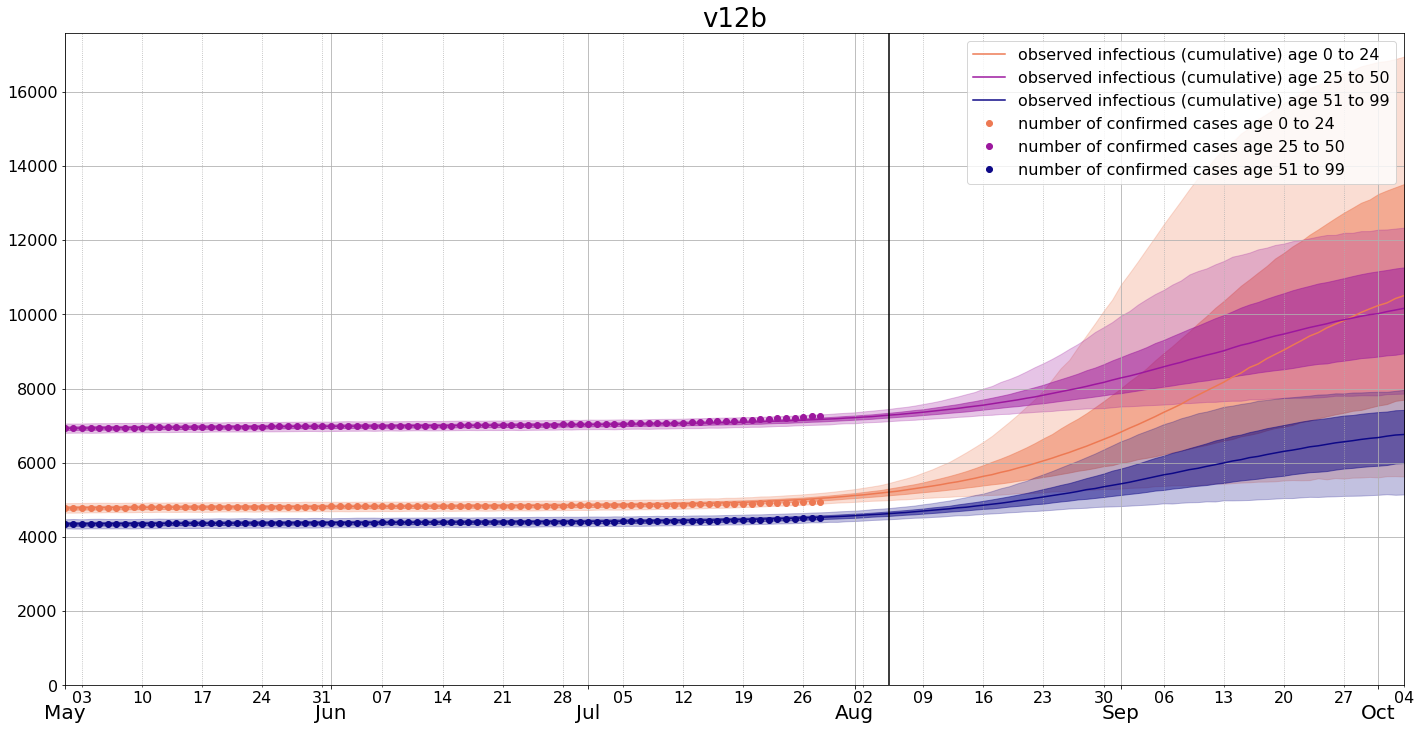

In [20]:
import matplotlib.dates as mdates

def create_quantile_plot(name, q, variables=('hospitalized',), title=None, daterange=None, show_data=True,
                         show_50p=True, show_90p=True, legendargs=None, ylim_bottom=0.0):
    fig,ax = plt.subplots()

    today = rewinddate
    if daterange is None:
        index = slice(None)
    else:
        index = np.logical_and(t_date >= daterange[0], t_date <= daterange[1])

    for v in variables:
        if q[v].ndim == 2:
            if show_90p:
                ax.fill_between(t_date[index], q[v][0,index], q[v][4,index], color=variable_colors[v], alpha=0.25)
            if show_50p:
                ax.fill_between(t_date[index], q[v][1,index], q[v][3,index], color=variable_colors[v], alpha=0.5)
            ax.plot(t_date[index], q[v][2,index], color=variable_colors[v], label=variable_desc[v])
        else:
            for iage in range(data['nage']):
                if show_90p:
                    ax.fill_between(t_date[index], q[v][0,iage,index], q[v][4,iage,index], color=age_colors[iage], alpha=0.25)
                if show_50p:
                    ax.fill_between(t_date[index], q[v][1,iage,index], q[v][3,iage,index], color=age_colors[iage], alpha=0.5)
                ax.plot(t_date[index], q[v][2,iage,index], color=age_colors[iage], label=variable_desc[v]+' '+age_group_desc[iage])

    if show_data:
        if 'Rmort' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(tobs_date['Rmort'] >= daterange[0], tobs_date['Rmort'] <= daterange[1])
            ax.plot(tobs_date['Rmort'][index], obs['Rmort'][index], ls='none', marker='D', markersize=10, color=variable_colors['Rmort'], label='number of deceased', zorder=4)
        if 'hospitalized' in variables or 'hospitalized+sigma' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(tobs_date['H'] >= daterange[0], tobs_date['H'] <= daterange[1])
            ax.plot(tobs_date['H'][index], obs['H'][index], ls='none', marker='H', markersize=10, color=variable_colors['hospitalized'], label='number of confirmed hospitalized', zorder=4)
        if 'Hicu' in variables or 'Hicu+sigma' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(tobs_date['H'] >= daterange[0], tobs_date['H'] <= daterange[1])
            ax.plot(tobs_date['H'][index], obs['Hicu'][index], ls='none', marker='^', markersize=10, color=variable_colors['Hicu'], label='number of confirmed ICU', zorder=4)
        if 'I' in variables or 'Iobs' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(tobs_date['I'] >= daterange[0], tobs_date['I'] <= daterange[1])
            for iage in range(data['nage']):
                ax.plot(tobs_date['I'][index], obs['I'][iage,index], ls='none', marker='o', color=age_colors[iage], label='number of confirmed cases '+age_group_desc[iage])

    if ylim_bottom is not None:
        ax.set_ylim(bottom=ylim_bottom) #, top =55000)

    if daterange is None or (today >= daterange[0] and today <= daterange[1]):
        ax.axvline(today.date(), color='black')

    if daterange is not None:
        ax.set_xlim(daterange)
    add_xaxis_datestyle(ax)
    if legendargs is None:
        ax.legend()
    else:
        ax.legend(**legendargs)

    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    return ax

# customize date range variables etc. here

for name in quantiles:
    ax = create_quantile_plot(name, quantiles[name], variables=('Iobs',), daterange=(t_date[0], t_date[-1]), title=desc[name])

None

## rate plots

In [21]:
daterange_export = (datetime.datetime(2021,5,1), datetime.datetime(2021,7,15))

today = rewinddate
# add 1st or 15th
min_lookahead = 20
for td in range(min_lookahead,50):
    d = today+datetime.timedelta(days=td)
    if d.day == 1 or d.day == 15:
        daterange_export = (d-datetime.timedelta(days=100), d)
        break

def create_rate_quantile_plot(fit, variables=('hospitalized',), title=None, daterange=None, show_50p=True, legendargs=None):
    for v in variables:
        if v in variable_index:
            prop = np.sum(fit['x'], axis=1)[:,variable_index[v],:]
        elif v == 'Iobs':
            prop = fit['obs_I_sim']
        elif v == 'I':
            x_noage = np.sum(fit['x'][:,:,:,:], axis=1)
            prop = x_noage[:,variable_index['Iasym'],:]+x_noage[:,variable_index['Imild'],:]+x_noage[:,variable_index['Ipreh'],:]
        else:
            prop = fit['hospitalized']

    qq = np.percentile(prop[:,1:]-prop[:,:-1], axis=0, q=(5,25,50,75,95))
    x = t_date[:-1] + 0.5 * (t_date[1:]-t_date[:-1])

    today = rewinddate
    if daterange is None:
        index = slice(None)
    else:
        index = np.logical_and(x >= daterange[0]-datetime.timedelta(days=1), x <= daterange[1]+datetime.timedelta(days=1))

    fig,ax = plt.subplots()
    for v in variables:
        ax.fill_between(x[index], qq[0,index], qq[-1,index], color=variable_colors[v], alpha=0.25)
        if show_50p:
            ax.fill_between(x[index], qq[1,index], qq[-2,index], color=variable_colors[v], alpha=0.5)
        if v == 'Rmort':
            label = 'daily death rate'
        elif v == 'hospitalized':
            label = 'daily hospitalization rate'
        else:
            label = '{} rate (d$^{{-1}}$)'.format(variable_desc[v])

        ax.plot(x[index], qq[2,index], color=variable_colors[v], label=label)

    if daterange is None or (today >= daterange[0] and today <= daterange[1]):
        ax.axvline(today.date(), color='black')

    if daterange is not None:
        ax.set_xlim(daterange)
    add_xaxis_datestyle(ax)
    if legendargs is None:
        ax.legend()
    else:
        ax.legend(**legendargs)

    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    return ax

#for name in fits:
#    ax = create_rate_quantile_plot(fits[name], variables=('Rmort',), title=desc[name], daterange=daterange_export)

## estimated fractions

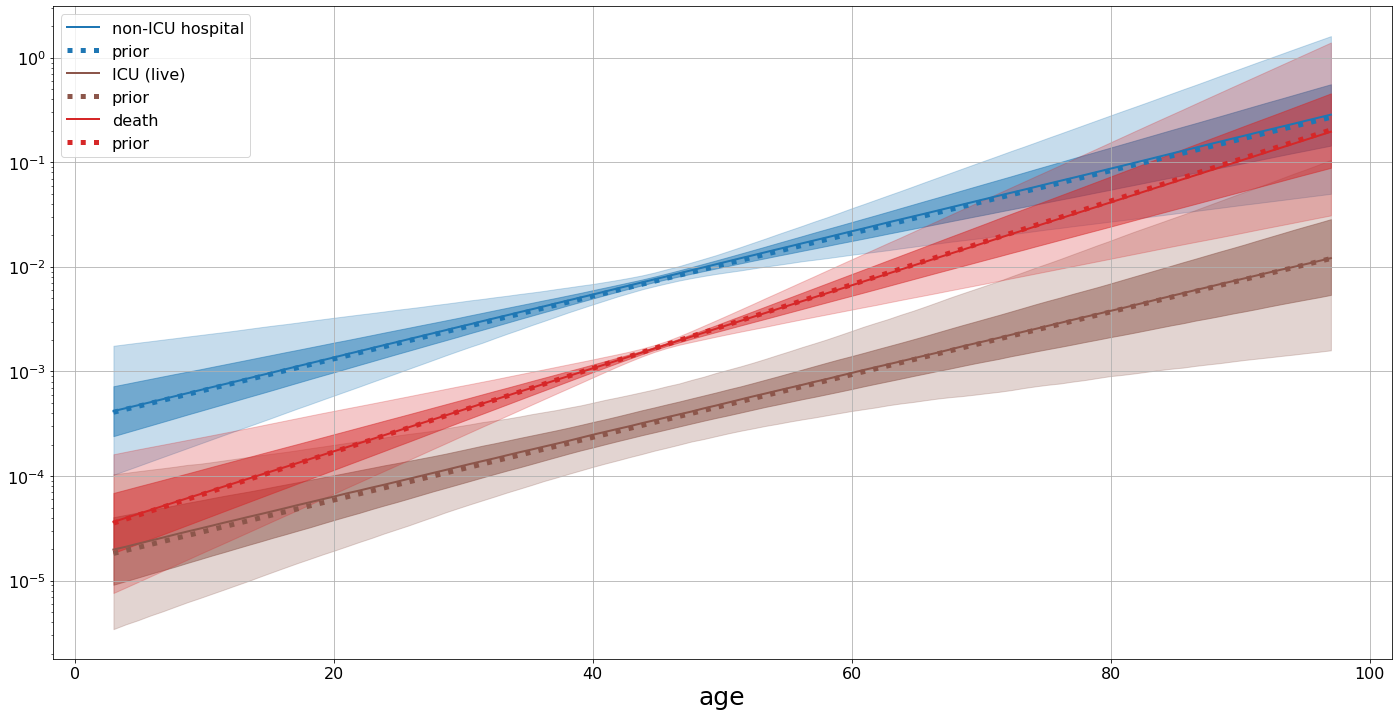

In [22]:
fate_colors = {'hospmild':'tab:blue', 'iculive':'tab:brown', 'mort':'tab:red'}
fate_desc = {
    'hospmild':'non-ICU hospital',
    'iculive':'ICU (live)',
    'mort':'death',
}

for name, fit in fits.items():
    if 'frac_hospmild_i45' in fit.flatnames:
        x = np.linspace(3, 97, 100)
        n = fits[name]['frac_hospmild_i45'].size

        fig, ax = plt.subplots()
        for prop in ('hospmild', 'iculive', 'mort'):
            inter = fits[name]['frac_{}_i45'.format(prop)]
            slope = fits[name]['frac_{}_slope'.format(prop)]

            tmp = np.empty((n, x.size))
            for i in range(n):
                tmp[i,:] = 10**((x-45.0)*slope[i] + inter[i])

            qq = np.percentile(tmp, q=(5,25,50,75,95), axis=0)
            fc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=fate_colors[prop])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, color=fc.get_facecolor()[0])
            ax.plot(x, qq[2,:], label=fate_desc[prop], lw=2, color=fc.get_facecolor()[0][:-1])

            x2 = np.array([3, 97])
            slope = data['mu_frac_'+prop+'_slope']
            inter = data['mu_frac_'+prop+'_i45']
            ax.plot(x2, 10**(slope*(x2-45.0) + inter), color=fate_colors[prop], lw=5, ls=':', label='prior')

        ax.legend()
        ax.set_yscale('log')
        ax.grid(True)
        ax.set_xlabel('age', size=25)

## plots for website / reports

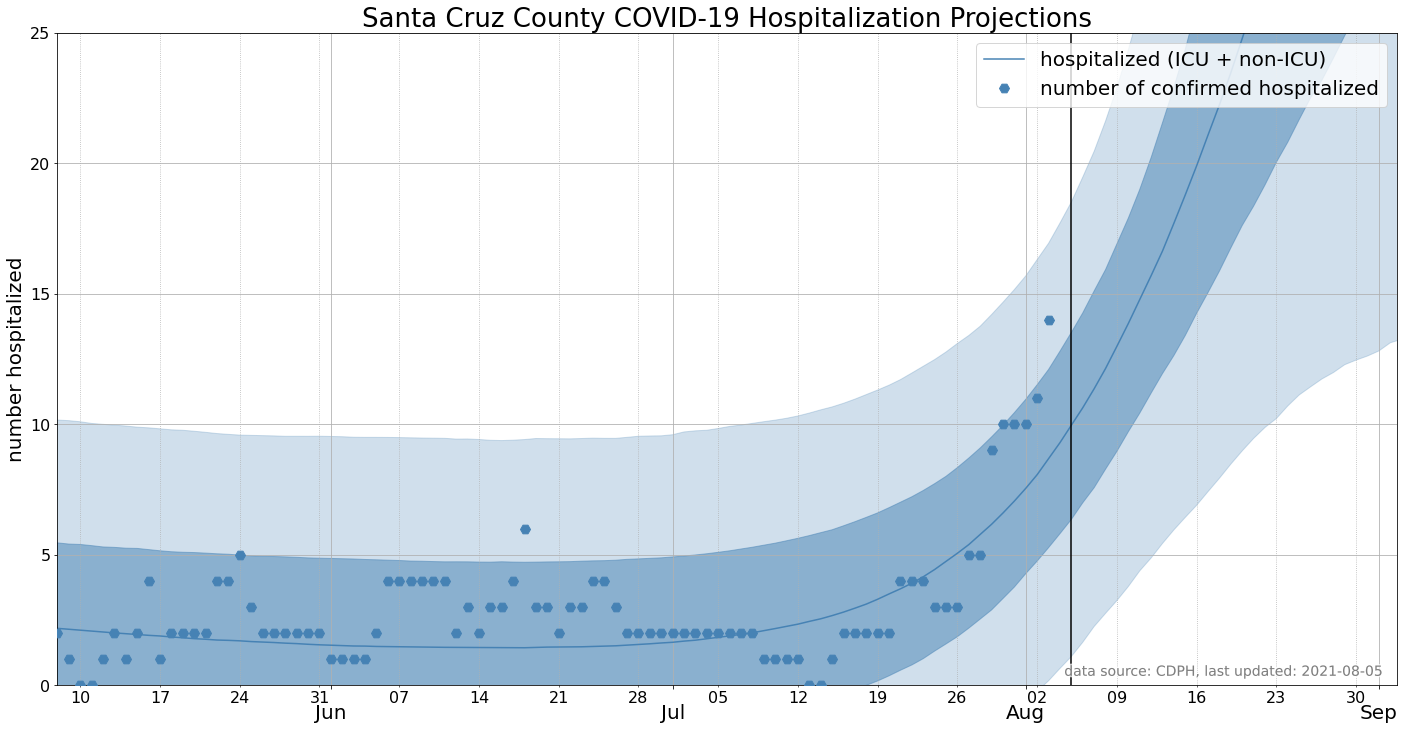

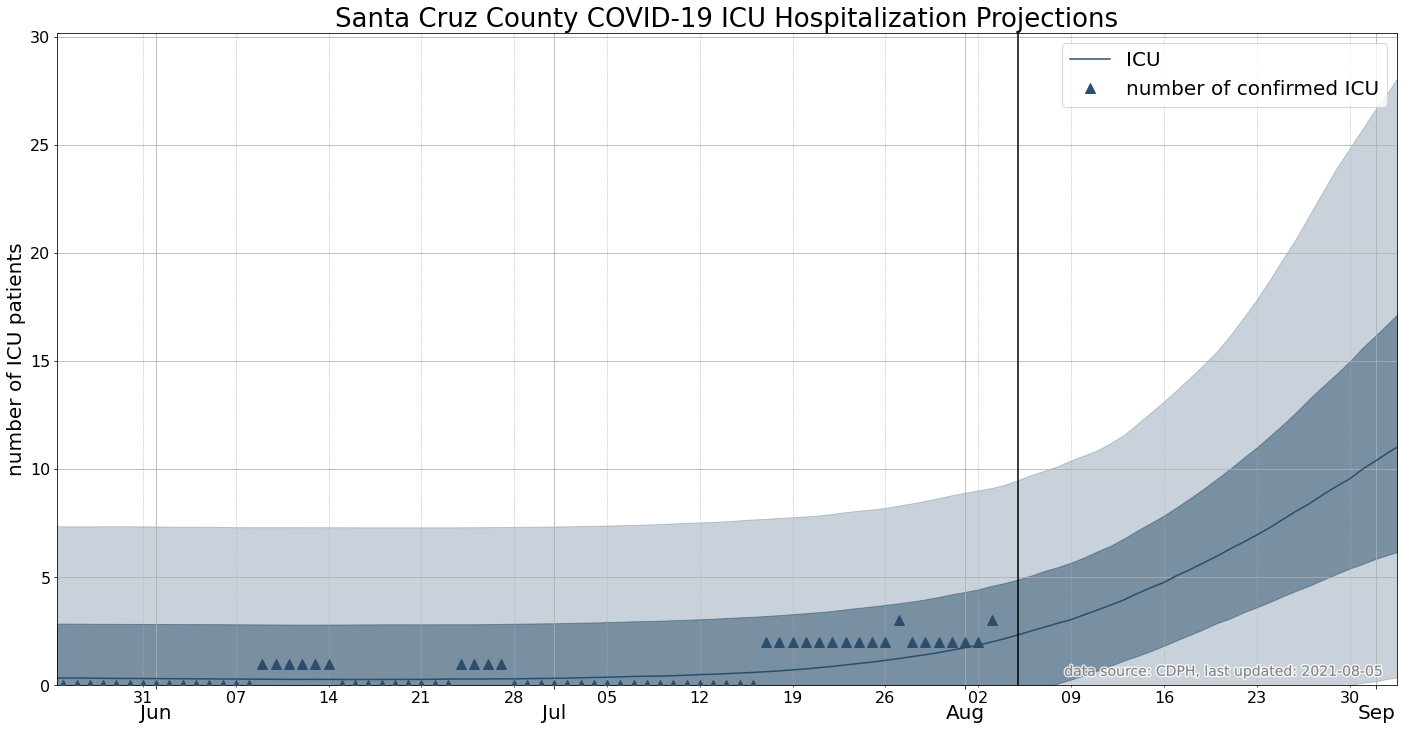

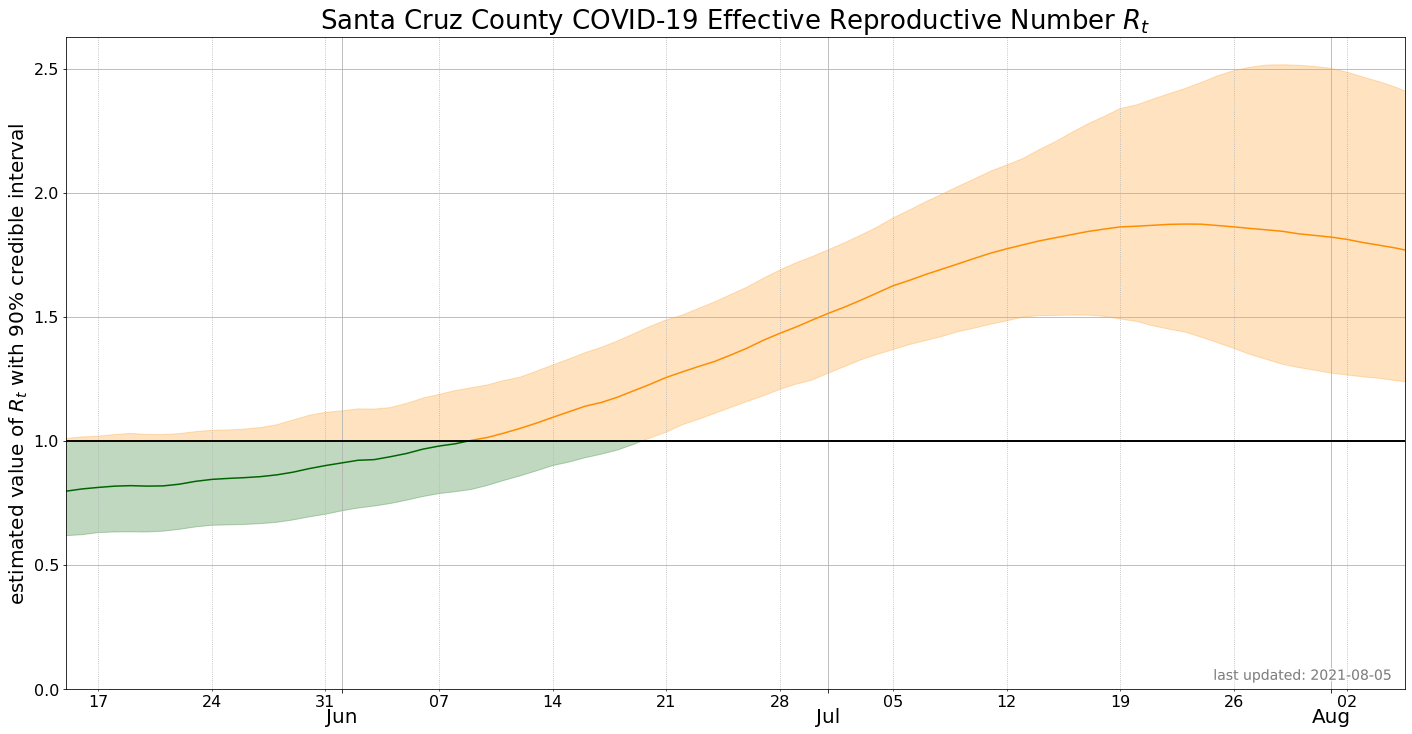

In [23]:
import matplotlib.patheffects as patheffects
path_effects=(patheffects.withStroke(linewidth=3,foreground='white',alpha=0.75),)

# temporarily overwrite
daterange_export = (daterange_export[0], rewinddate + datetime.timedelta(days=28))
daterange_plot = (daterange_export[0]-datetime.timedelta(days=1), daterange_export[-1]+datetime.timedelta(days=1))

for name in quantiles:
    if name in ('v12b', 'v12b_14+20', 'v12b_14+50', 'v12b_14+100'):
        modelname = {'v12b':'SEIR_v12b',
                     'v12b_14+20':'SEIR_v12b_scenario14+20',
                     'v12b_14+50':'SEIR_v12b_scenario14+50',
                     'v12b_14+100':'SEIR_v12b_scenario14+100'}[name]
        title_prefix = {'v12b':'',
                        'v12b_14+20':'scenario: $\\beta$+20% (14 days) ',
                        'v12b_14+50':'scenario: $\\beta$+50% (14 days) ',
                        'v12b_14+100':'scenario: $\\beta$+100% (14 days) ',
                       }[name]

        #
        # hospitalizations
        #

        ax = create_quantile_plot(name, quantiles[name], variables=('hospitalized+sigma',), 
                                  title=None, show_50p=True, show_90p=True, show_data=True, 
                                  legendargs={'fontsize':20, 'loc':'upper right'})
        ax.set_ylim([0,25])

        fig = ax.get_figure()
        fig.patch.set_alpha(0)
        ax.set_ylabel('number hospitalized', size=20)
        ax.set_title(title_prefix + 'Santa Cruz County COVID-19 Hospitalization Projections', size=26)
        ax.set_xlim(left=t_date[7], right=daterange_export[1])
        if ax.get_ylim()[1] < 7:
            ax.set_ylim(top=7)

        text_right = True
        if text_right:
            ax.text(0.99,0.01,'data source: CDPH, last updated: {}'.format(rewinddate.date()), transform=ax.transAxes, 
                    va='bottom', ha='right', size=14, color='tab:gray', path_effects=path_effects)
        else:
            ax.text(0.01,0.01,'data source: CDPH, last updated: {}'.format(rewinddate.date()), transform=ax.transAxes, 
                    va='bottom', ha='left', size=14, color='tab:gray', path_effects=path_effects)
            #ax.text(0.99,0.95,'433 total acute beds (licensed and surge)', transform=ax.transAxes, va='top', ha='right', size=26, color=variable_colors['Hicu'], path_effects=path_effects)

        #
        # ICU
        #

        ax = create_quantile_plot(name, quantiles[name], variables=('Hicu+sigma',), daterange=daterange_plot,
                                  title=None, show_50p=True, show_90p=True, show_data=True,
                                  legendargs={'fontsize':20, 'loc':'upper right'})
        #ax.set_ylim([0,15])

        fig = ax.get_figure()
        fig.patch.set_alpha(0)
        ax.set_ylabel('number of ICU patients', size=20)
        ax.set_title(title_prefix + 'Santa Cruz County COVID-19 ICU Hospitalization Projections', size=26)
        ax.set_xlim(daterange_export)
        if ax.get_ylim()[1] < 7:
            ax.set_ylim(top=7)

        if text_right:
            ax.text(0.99,0.01,'data source: CDPH, last updated: {}'.format(rewinddate.date()), transform=ax.transAxes,
                    va='bottom', ha='right', size=14, color='tab:gray', path_effects=path_effects)
        else:
            ax.text(0.01,0.01,'data source: CDPH, last updated: {}'.format(rewinddate.date()), transform=ax.transAxes,
                    va='bottom', ha='left', size=14, color='tab:gray', path_effects=path_effects)

        #
        # Rt plots
        #

        def _insert_crossings(x, y, yval=1.0):
            crossings = (y[1:] - yval) * (y[:-1] - yval) < 0

            num_crossings = np.sum(crossings)
            ind_crossings = np.flatnonzero(crossings) + 1

            y_new = np.empty(y.size + num_crossings)
            x_new = np.empty(x.size + num_crossings, dtype=x.dtype)

            i0 = 0
            i0_new = 0
            for i, i1 in enumerate(ind_crossings):
                i1_new = i1 + i

                y_new[i0_new:i1_new] = y[i0:i1]
                y_new[i1_new] = yval

                alpha = (1.0 - y[i1-1]) / (y[i1] - y[i1-1])
                x_new[i0_new:i1_new] = x[i0:i1]
                #x_new[i1_new] = alpha * x[i1] + (1.0-alpha) * x[i1-1]
                x_new[i1_new] = x[i1] + (1.0-alpha) * (x[i1-1] - x[i1])

                i0 = i1
                i0_new = i1_new + 1

            y_new[i0_new:] = y[i0:]
            x_new[i0_new:] = x[i0:]

            return x_new, y_new

        def plot_rt(ax, t_date, qq):
            # bit of a hack to get inserts where either qq[0,:] or qq[-1,:] passes through zero
            x, y0 = _insert_crossings(t_date, qq[0,:])
            y1, _ = _insert_crossings(qq[-1,:], qq[0,:])

            x, _ = _insert_crossings(x, y1)
            y0, y1 = _insert_crossings(y0, y1)

            ax.fill_between(x, np.maximum(y0,1), np.maximum(y1,1), color='darkorange', alpha=0.25)
            ax.fill_between(x, np.minimum(y0,1), np.minimum(y1,1), color='darkgreen', alpha=0.25)

            x, y = _insert_crossings(t_date, qq[2,:])

            ax.plot(x, np.maximum(y,1), color='darkorange', label='$R_t$ estimate')
            ax.plot(x, np.minimum(y,1), color='darkgreen')

            ax.axhline(1.0, color='black')


        fit = fits[name]
        if 'Rt[1]' in fit.flatnames:
            qq = np.percentile(fit['Rt'], axis=0, q=(5,25,50,75,95))

            #
            # Rt standard plot
            #

            fig, ax = plt.subplots()
            fig.patch.set_alpha(0)
            ax.set_title(title_prefix + 'Santa Cruz County COVID-19 Effective Reproductive Number $R_t$', size=26)
            ax.set_ylabel('estimated value of $R_t$ with 90% credible interval', size=20)

            plot_rt(ax, t_date, qq)

            ax.grid(True)
            add_xaxis_datestyle(ax)
            #add_intervention_info(ax)

            ax.axhline(1.0, color='black')
            ax.set_ylim(bottom=0.0)
            ax.set_xlim(left=t_date[14], right=rewinddate)

            ax.text(0.99,0.01,'last updated: {}'.format(rewinddate.date()), transform=ax.transAxes,
                    va='bottom', ha='right', size=14, color='tab:gray', path_effects=path_effects)

## model checks & diagnostics

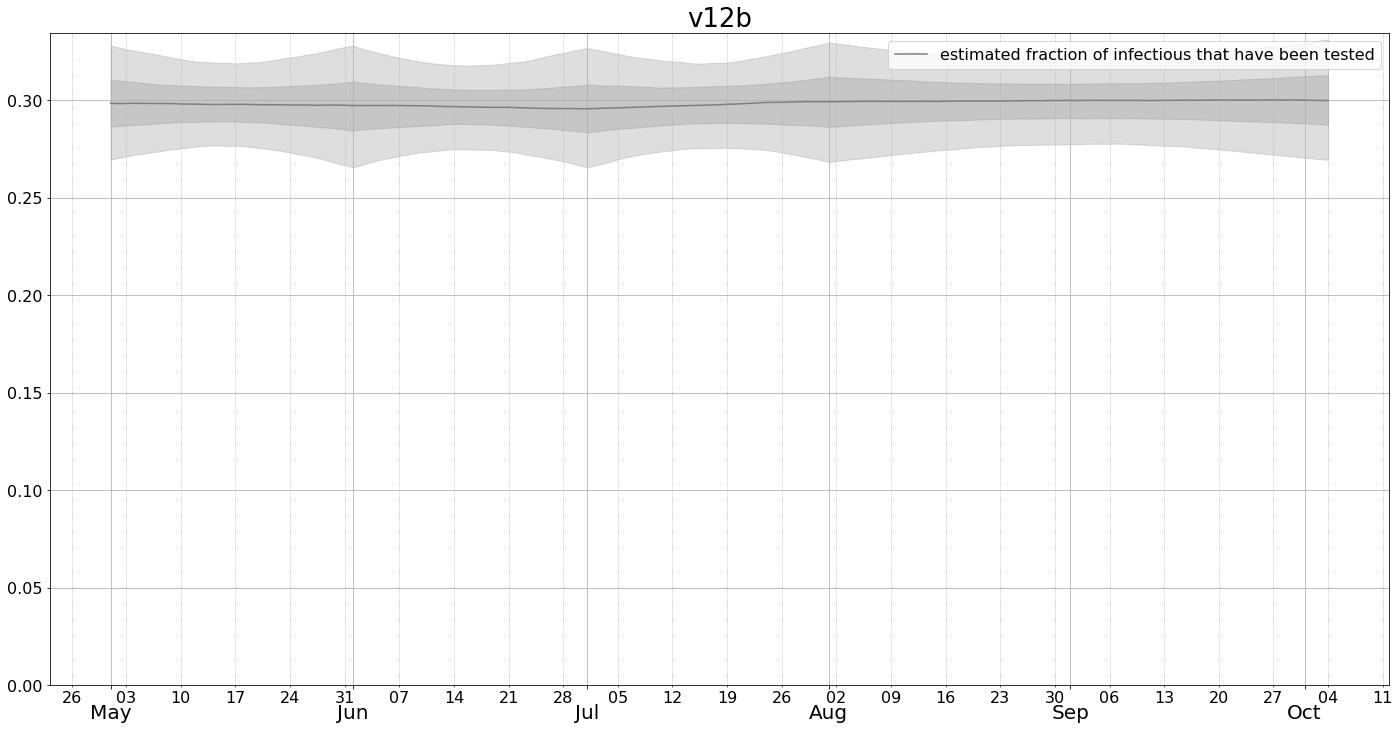

In [24]:
for name,fit in fits.items():
    '''
    if 'fractested[1]' in fit.flatnames:
        qq = np.percentile(fit['fractested'], axis=0, q=(5,25,50,75,95))

        fig,ax = plt.subplots()

        ax.fill_between(tobs_date['I'], qq[0,:], qq[-1,:], color='tab:grey', alpha=0.25)
        ax.fill_between(tobs_date['I'], qq[1,:], qq[-2,:], color='tab:grey', alpha=0.25)
        ax.plot(tobs_date['I'], qq[2,:], color='tab:grey', label='estimated fraction of infectious that have been tested (cumulative number)')

        ax.set_ylim(bottom=0.0)
        if ax.get_ylim()[1] > 1.0:
            ax.axhline(1.0, color='darkred', ls='--')
        ax.set_title(desc[name])
        add_xaxis_datestyle(ax)
        ax.grid(True)
        ax.legend()
    '''
    if 'fractest[1]' in fit.flatnames:
        qq = np.percentile(fit['fractest'], axis=0, q=(5,25,50,75,95))

        fig,ax = plt.subplots()

        ax.fill_between(t_date, qq[0,:], qq[-1,:], color='tab:grey', alpha=0.25)
        ax.fill_between(t_date, qq[1,:], qq[-2,:], color='tab:grey', alpha=0.25)
        ax.plot(t_date, qq[2,:], color='tab:grey', label='estimated fraction of infectious that have been tested')

        ax.set_ylim(bottom=0.0)
        if ax.get_ylim()[1] > 1.0:
            ax.axhline(1.0, color='darkred', ls='--')
        ax.set_title(desc[name])
        add_xaxis_datestyle(ax)
        ax.grid(True)
        ax.legend()

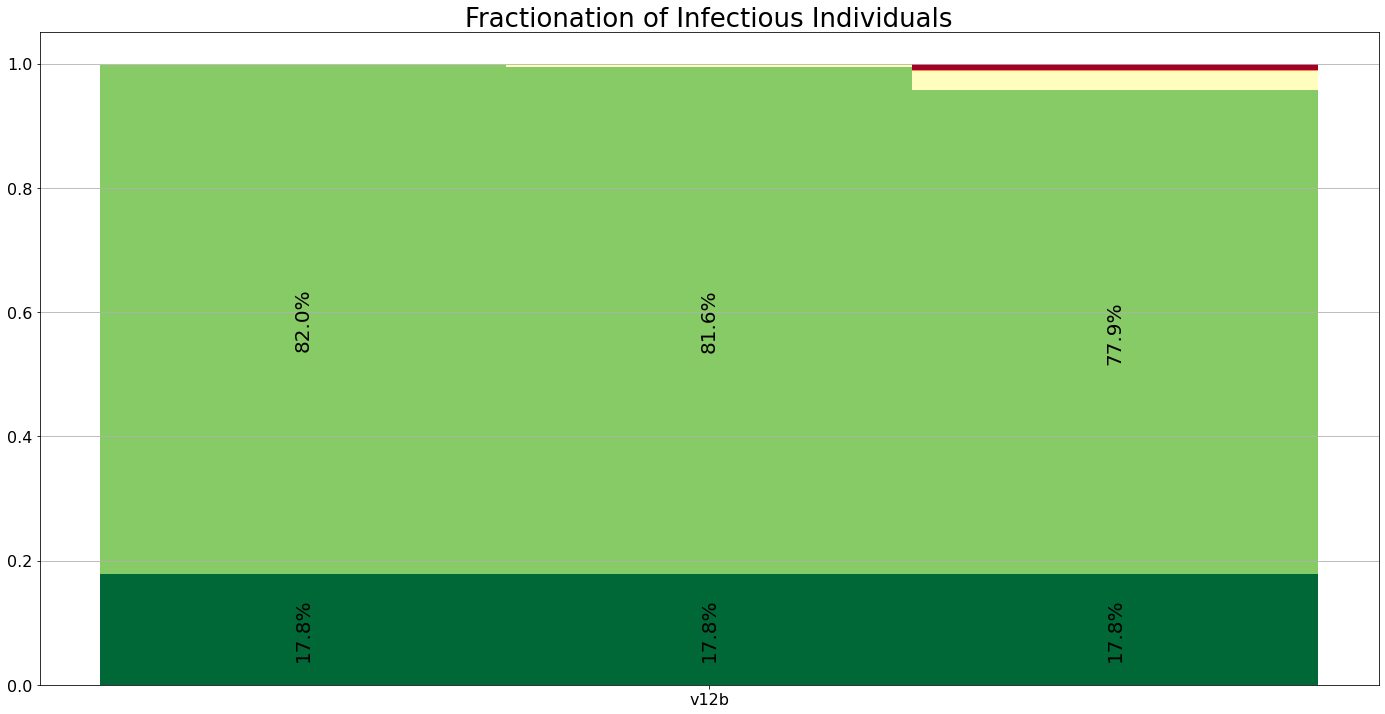

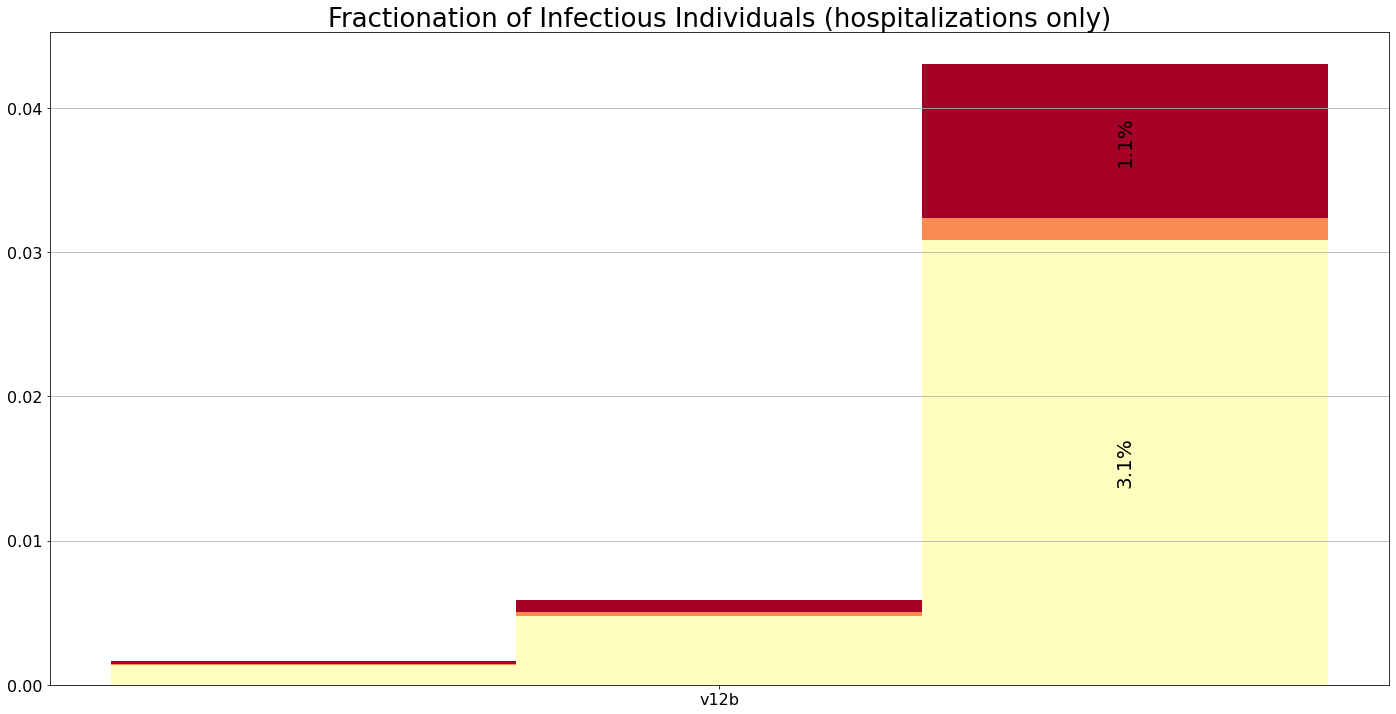

In [25]:
nage = data['nage']

if 'frac_hosp' in data:
    frac_I_agg = np.zeros((len(fits)+1,nage,5))
    # prior goes in first column
    frac_I_agg[0,:,0] = data['frac_asym']
    frac_I_agg[0,:,2] = data['frac_hosp'] - data['frac_icu']
    frac_I_agg[0,:,3] = data['frac_icu'] - data['frac_mort']
    frac_I_agg[0,:,4] = data['frac_mort']
    frac_I_agg[0,:,1] = 1.0 - np.sum(frac_I_agg[0,:,:], axis=1)

    for i,name in enumerate(fits):
        frac_I_agg[i+1,:,:] = np.mean(fits[name]['frac_I'], axis=0)
    names = ['prior',*list(fits.keys())]
else:
    frac_I_agg = np.zeros((len(fits),nage,5))
    for i,name in enumerate(fits):
        frac_I_agg[i,:,:] = np.mean(fits[name]['frac_I'], axis=0)
    names = list(fits.keys())

cmap = plt.get_cmap('RdYlGn_r')
colors = [cmap(i/4) for i in range(5)]
desc['prior'] = 'prior'
labels = ['asymptomatic','mild','hospital (non-ICU)','ICU (non-fatal)', 'ICU (fatal)']

fig, ax = plt.subplots()
ax.set_title('Fractionation of Infectious Individuals')
bottom=np.zeros(5)
for i,name in enumerate(names):
    x = i + np.linspace(0, 1, nage+2)[:-1]
    for iage in range(nage):
        height = frac_I_agg[i,iage,:]
        bottom[1:] = np.cumsum(height)[:-1]
        ax.bar(x=x[iage], height=height, width=x[1]-x[0], bottom=bottom, color=colors)
        for iy in range(len(height)):
            if height[iy] > 0.1:
                #ax.text(x[iage],bottom[iy]+0.5*height[iy], '{}\n{:.1%}'.format(labels[iy],height[iy]), size=20, va='center', ha='center')
                ax.text(x[iage],bottom[iy]+0.5*height[iy], '{:.1%}'.format(height[iy]), rotation=90, size=20, va='center', ha='center')

ax.set(xticks=np.arange(len(names))+0.25, xticklabels=[desc[name] for name in names])
ax.yaxis.grid(True)

fig, ax = plt.subplots()
ax.set_title('Fractionation of Infectious Individuals (hospitalizations only)')
bottom=np.zeros(3)
for i,name in enumerate(names):
    x = i + np.linspace(0, 1, nage+2)[:-1]
    for iage in range(frac_I_agg.shape[1]):
        height = frac_I_agg[i,iage,2:]
        bottom[1:] = np.cumsum(height)[:-1]
        ax.bar(x=x[iage], height=height, width=x[1]-x[0], bottom=bottom, color=colors[2:])
        for iy in range(len(height)):
            if height[iy] > 0.01:
                #ax.text(x[iage],bottom[iy]+0.5*height[iy], '{}\n{:.1%}'.format(labels[iy],height[iy]), size=20, va='center', ha='center')
                ax.text(x[iage],bottom[iy]+0.5*height[iy], '{:.1%}'.format(height[iy]), rotation=90, size=20, va='center', ha='center')

ax.set(xticks=np.arange(len(names))+0.25, xticklabels=[desc[name] for name in names])
ax.yaxis.grid(True)

None